# Model validation water levels

Note: this notebook requires the model output data

In [42]:
import mikeio
import modelskill as ms
import matplotlib.pyplot as plt 
import helper as h

In [43]:
ms.options.metrics.list = ["rmse", "mae", "cc", "si", "r2"]

Instead of reading the entire dfsu (`Area.dfsu`), we can simply load the outputted points (dfs0) since they correspond to the locations we have observations from.

In [44]:
mr_fldr = "../output/"    
# mr_fldr = "../output_sample/"     # use this if you have not downloaded the full data from Zenodo yet
save_png = False if "sample" in mr_fldr else True
fig_fldr = "../figures/" 


Model results data are stored in a dfs0 file. We can use [MIKE IO](https://dhi.github.io/mikeio) read the data to a MIKE IO Dataset.

Note: The first two spin-up days are excluded.

In [45]:
ds = mikeio.read(f"{mr_fldr}Points.dfs0", items="*Surf*", time = slice("2022-01-03", None))
ds.items

[NWA: Surface elevation <Surface Elevation> (meter),
 IJVA: Surface elevation <Surface Elevation> (meter),
 DDW1A: Surface elevation <Surface Elevation> (meter),
 F3platform: Surface elevation <Surface Elevation> (meter),
 K13a: Surface elevation <Surface Elevation> (meter),
 Europlatform: Surface elevation <Surface Elevation> (meter),
 J61: Surface elevation <Surface Elevation> (meter)]

## Compare to water level station observations

The [ModelSkill package](https://dhi.github.io/modelskill/) can be used to compare model results with observations.

In [46]:
wllist = h.get_wl_point_obs()

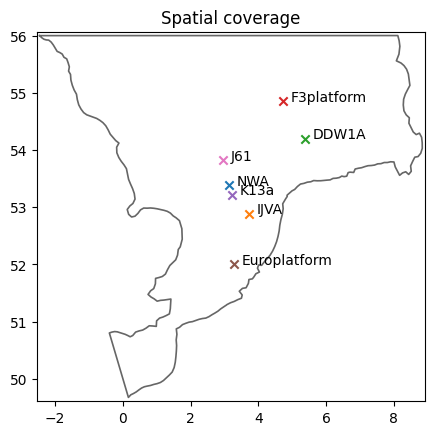

In [47]:
msh = mikeio.open("../input/Mesh_8000_elems_HD_v2.mesh")
ms.plotting.spatial_overview(wllist, mod=msh);

Match the right model result timeseries and observation. Also, remove the bias (different vertical datum).

In [48]:
cmps = []
for o in wllist:
    mr = ms.PointModelResult(ds[o.name+": Surface elevation"], name="MIKE21")
    try:
        cmp = ms.match(obs=o, mod=mr)
    except Exception as e:
        print(e)
    cmps.append(cmp.remove_bias())
cc = ms.ComparerCollection(cmps)

## Skill table

In [49]:
cc.skill().round(3)

,n,rmse,mae,cc,si,r2
observation,,,,,,
NWA,26289,0.171,0.140,0.938,0.420,0.877
IJVA,26551,0.161,0.129,0.893,0.558,0.792
DDW1A,9824,0.152,0.110,0.927,0.452,0.860
F3platform,34913,0.129,0.105,0.871,0.641,0.736
K13a,33791,0.176,0.139,0.923,0.469,0.850
Europlatform,34464,0.208,0.153,0.939,0.408,0.879
J61,34942,0.185,0.140,0.946,0.394,0.889


We can see from the skill table that the model has an RMSE of 6.5-9.7 cm. 

## Example timeseries

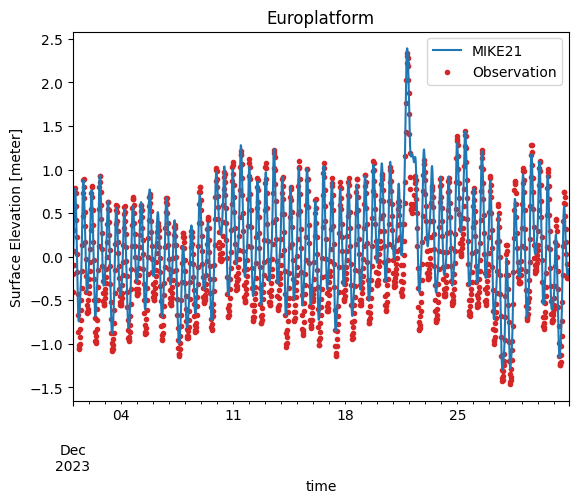

In [50]:
t_plot = slice("2023-12-01","2023-12-31") if "2023-12-01" in ds.time else slice(None, None)
cc["Europlatform"].sel(time=t_plot).plot.timeseries();

## Scatter plots

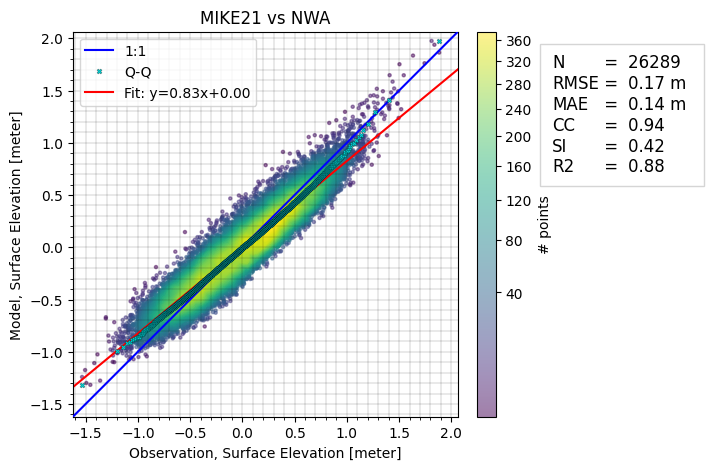

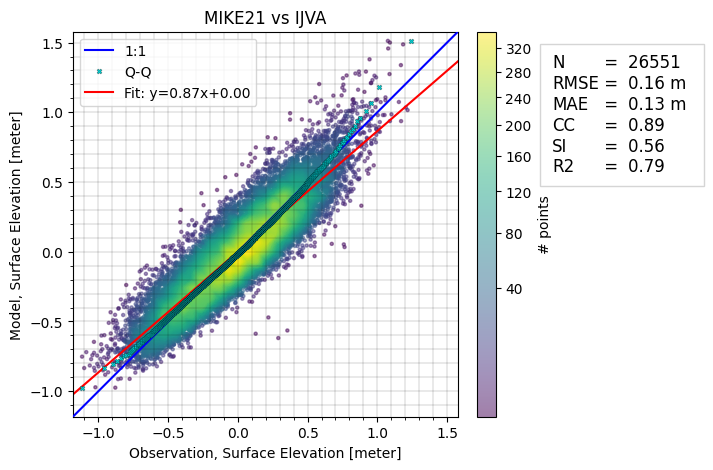

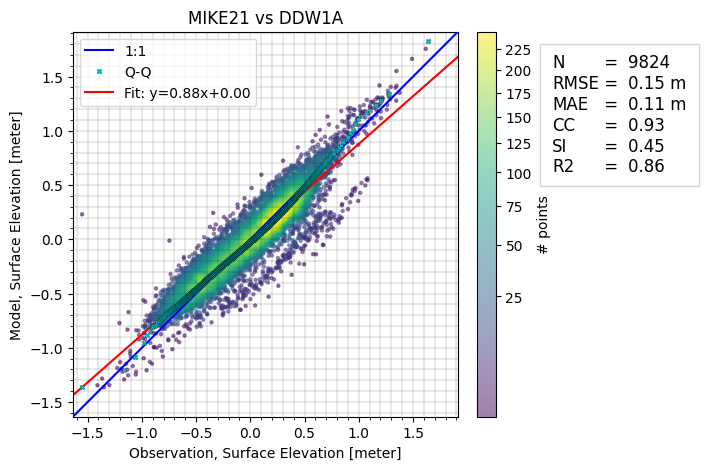

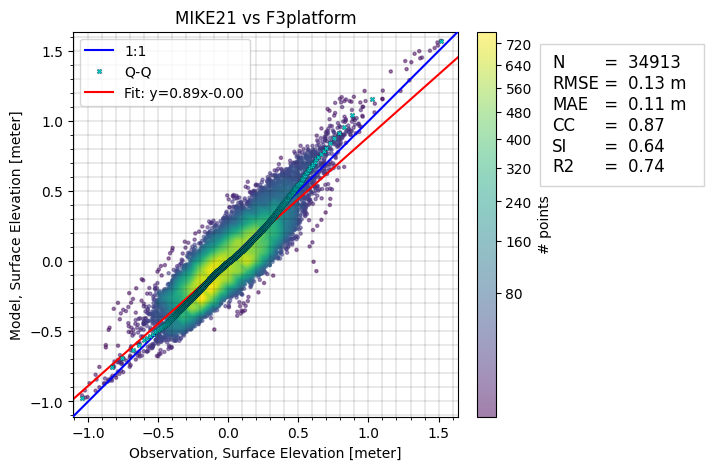

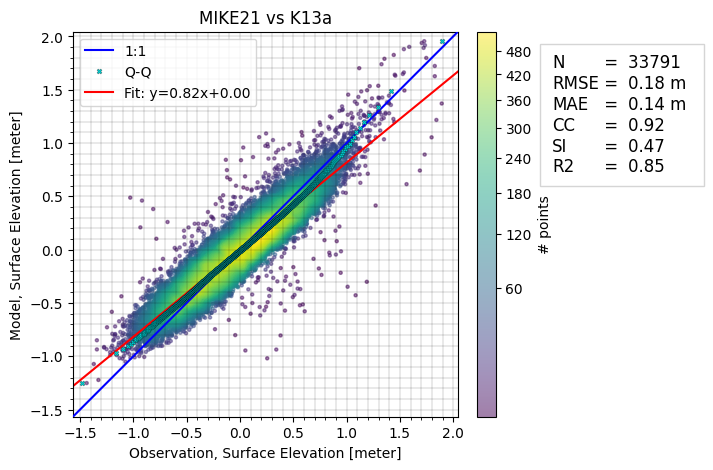

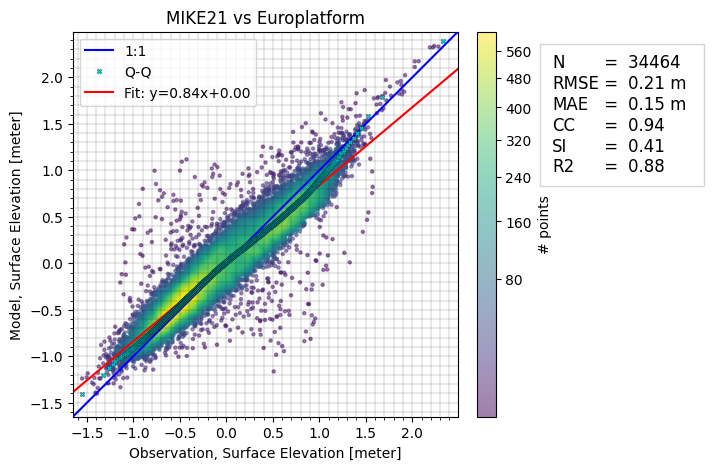

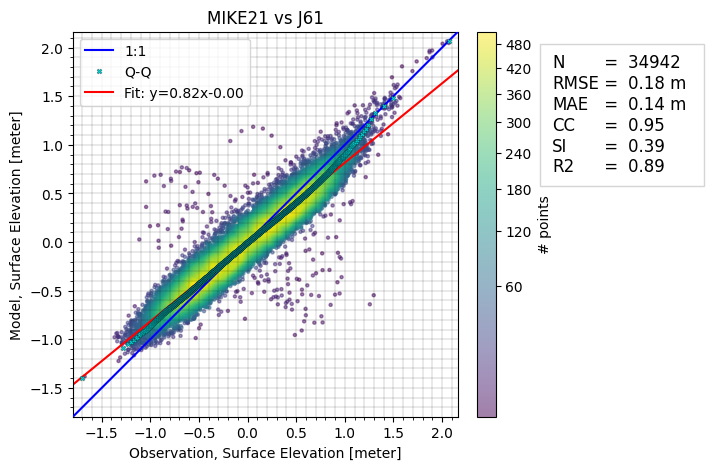

In [51]:
n_points_shown = 20000
for cmp in cc:
    cmp.plot.scatter(skill_table=True, show_points=n_points_shown, figsize=(6,5), bins=40);
    if save_png:
        plt.savefig(f"{fig_fldr}modelskill_comparison_{cmp.name}.png", bbox_inches='tight');